In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.data import Data
from rdkit import Chem, RDLogger
from src.data_utils import collate_fn



atom_type = {'C': 0, 'N': 1, 'O': 2, 'F': 3, 'S': 4, 'P': 5, 'Cl': 6, 'Br': 7, 'I': 8}
bond_type = {'SINGLE': 1, 'DOUBLE': 2, 'TRIPLE': 3}


def from_smiles(smiles: str) -> 'torch_geometric.data.Data':
    RDLogger.DisableLog('rdApp.*')

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')
    Chem.Kekulize(mol)

    x = []
    for atom in mol.GetAtoms():
        x.append(atom_type[atom.GetSymbol()])
    x = torch.tensor(x, dtype=torch.long)
    x = F.one_hot(x, num_classes=len(atom_type)).to(torch.float)

    adj = torch.zeros((mol.GetNumAtoms(), mol.GetNumAtoms()), dtype=torch.float)

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = bond_type[str(bond.GetBondType())]
        adj[i, j] = e
        adj[j, i] = e

    return Data(x=x, adj=adj, smiles=smiles)



class ZINCDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        data = from_smiles(row['smiles'])
        data.adj = data.adj / 3
        data.aromatic_rings = torch.tensor(row['aromatic_rings'], dtype=torch.long)
        data.aliphatic_rings = torch.tensor(row['aliphatic_rings'], dtype=torch.long)
        data.hb_donors = torch.tensor(row['hb_donor_count'], dtype=torch.long)
        data.hb_acceptors = torch.tensor(row['hb_acceptor_count'], dtype=torch.long)

        return data

In [9]:
import pandas as pd
from src.data_utils import collate_fn


df = pd.read_csv('../../data/ZINC/zinc_250k_counted.csv')
dataset = ZINCDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
batch = next(iter(dataloader))
X, E, mask = batch
print(X.shape, E.shape, mask.shape)

torch.Size([32, 32, 9]) torch.Size([32, 32, 32]) torch.Size([32, 32])


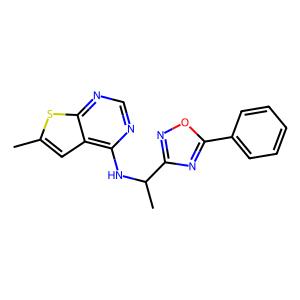

In [18]:
from src.data_utils import drop_masked, data_to_mol, mol_to_pil, valid_mol_to_pil

i = 2

x, e = drop_masked(X[i], E[i])
mol = data_to_mol(x, e)
pil = valid_mol_to_pil(mol)
pil